In [28]:
import numpy as np
import cv2
from skimage.external import tifffile as tiff
from skimage import exposure
from skimage.filters import try_all_threshold, threshold_li
from skimage.transform import rescale
from skimage import measure

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline


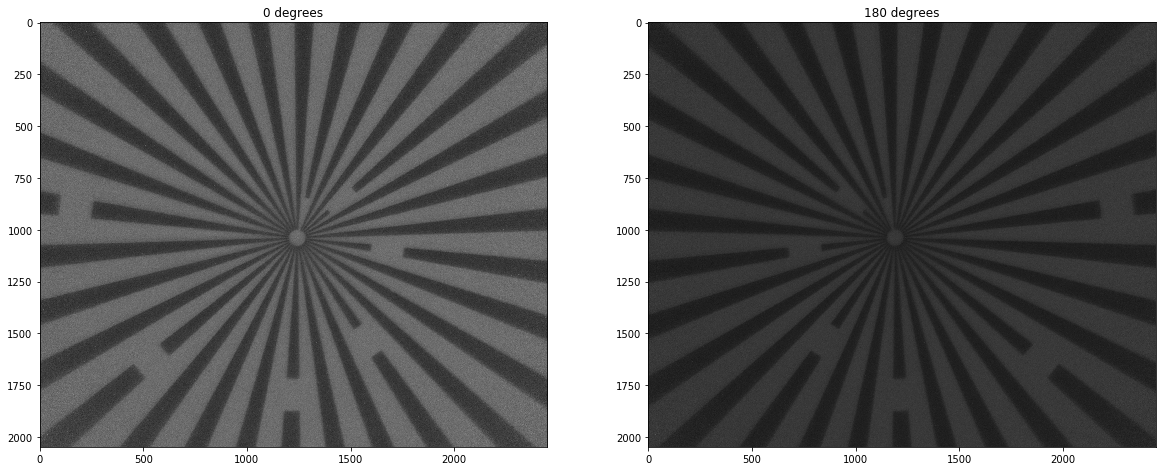

In [2]:
samples = ['./samples/rot_0.tif', 
           './samples/rot_180.tif',
           './samples/faked_rot_0_titled_5.3deg.tif',
           './samples/faked_rot_180.tif']

img0 = tiff.imread(samples[0])
img180 = tiff.imread(samples[1])

fig = plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img0, cmap='gray')
plt.title("0 degrees")
plt.subplot(122)
plt.imshow(img180, cmap='gray')
plt.title("180 degrees")
plt.show()


### Rescale image to speed up processing. Rescale to only 40% of the size. 

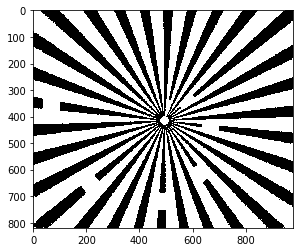

In [3]:
img0_rescaled = rescale(img0, 0.4, mode='reflect')
thresh = threshold_li(img0_rescaled)
binary = img0_rescaled > thresh

plt.imshow(binary, cmap='gray')
plt.show()

In [4]:
# Create few empty image for processing. 

img0_empty = np.zeros_like(binary, dtype=np.uint8)
img0_binary = np.zeros_like(binary, dtype=np.uint8)
img0_binary_inv = np.zeros_like(binary, dtype=np.uint8)

img0_binary[binary] = 255
img0_binary_inv[~binary] = 255

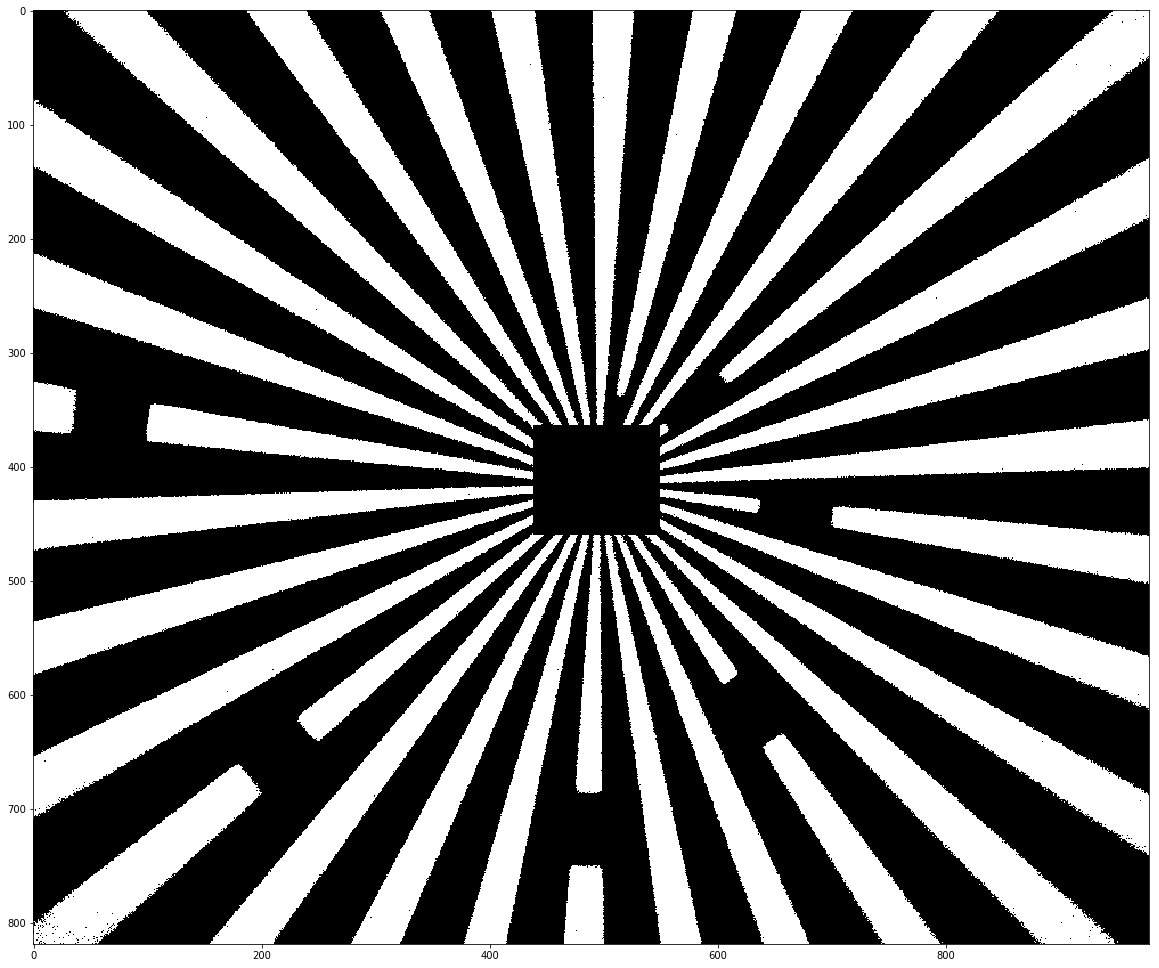

In [5]:
# Mask out center of image. 
h, w = img0_binary.shape
img0inv_masked = img0_binary_inv.copy()
mask = np.zeros_like(img0_binary, dtype=np.uint8)

vertices = np.array([[
                (w/2 - 50, h/2 - 45),
                (w/2 + 60, h/2 - 45), 
                (w/2 + 60, h/2 + 50), 
                (w/2 - 50, h/2 + 50)
            ]], 
                        dtype=np.int32)

cv2.fillPoly(mask, vertices, 255)
masked = cv2.bitwise_and(img0inv_masked, mask)
img0inv_masked[masked > 0] = 0

plt.figure(figsize=(20, 20))
plt.imshow(img0inv_masked, cmap='gray')
plt.show()



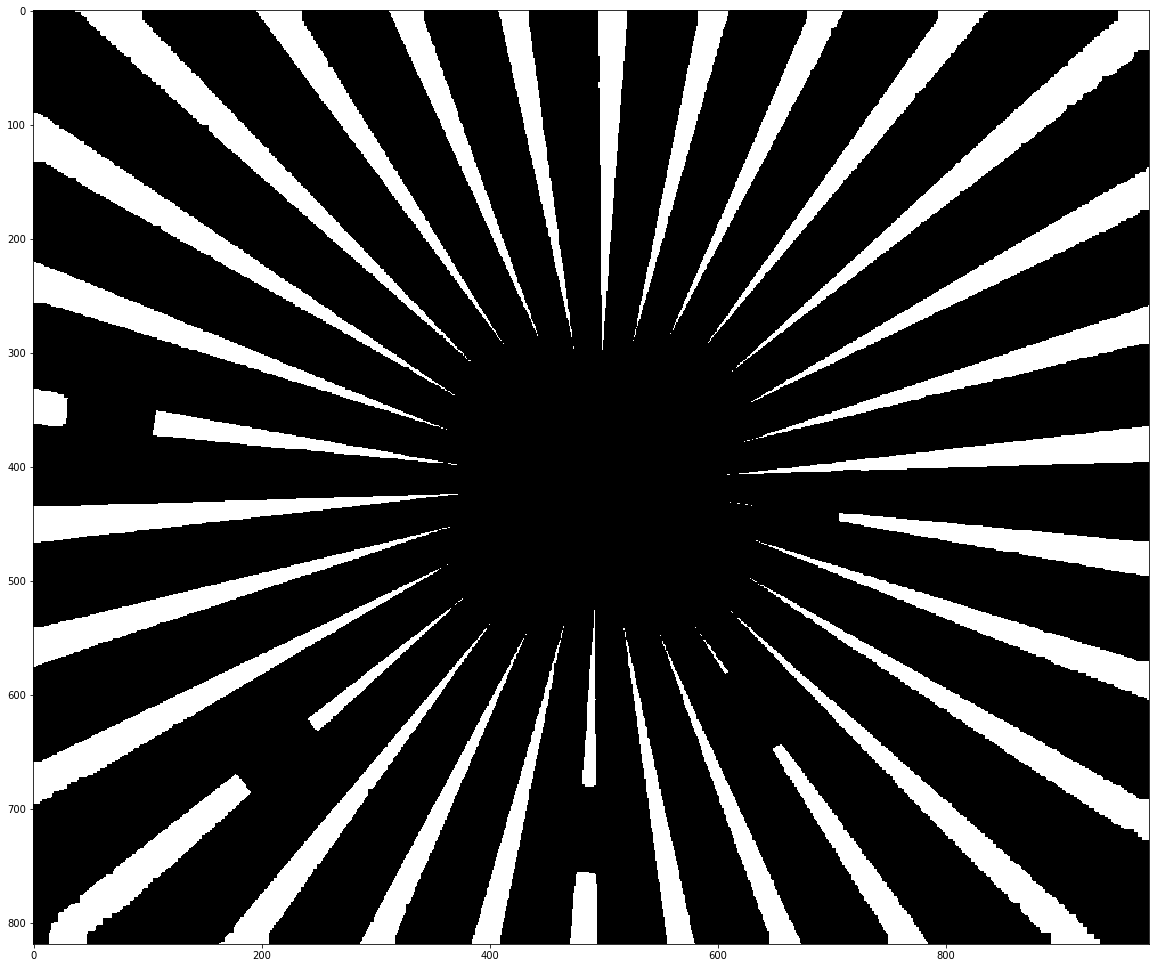

In [24]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(img0inv_masked,cv2.MORPH_OPEN, kernel, iterations = 2)
erosion = cv2.erode(fg, kernel, iterations = 7)
fg = cv2.dilate(opening,kernel,iterations=2)

plt.figure(figsize=(20, 20))
plt.imshow(erosion, cmap='gray')
plt.show()

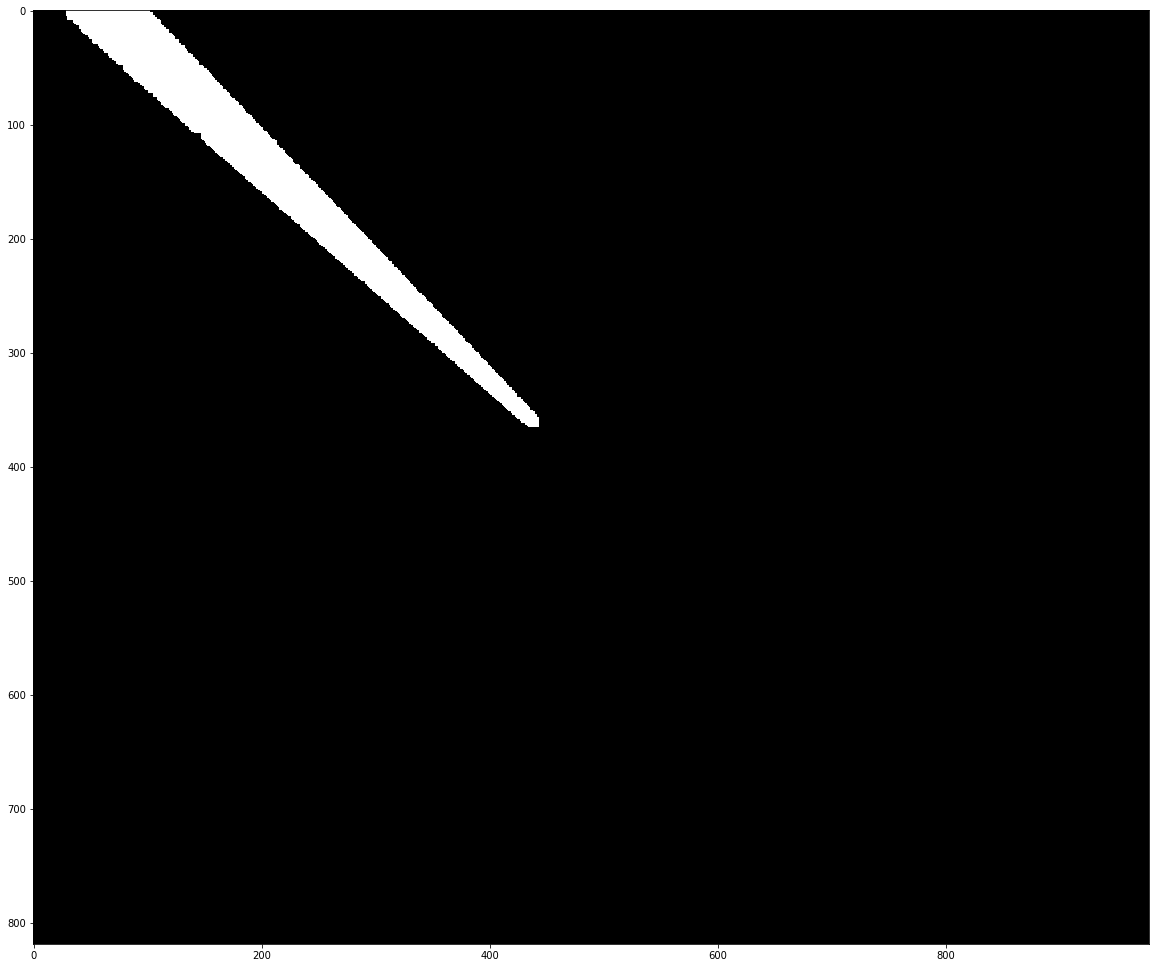

In [32]:
labels = measure.label(fg, neighbors=8, background=0)
mask = np.zeros(fg.shape, dtype="uint8")

for label in np.unique(labels):
    # if this is the background label, ignore it
    if label == 0:
        continue
    
    labelMask = np.zeros(fg.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv2.countNonZero(labelMask)
 
    if numPixels > 300:
        mask = cv2.add(mask, labelMask)
    
    # if the number of pixels in the component is sufficiently
    # large, then add it to our mask of "large blobs"
    if numPixels > 300:
        mask = cv2.add(mask, labelMask)
    
plt.figure(figsize=(20, 20))
plt.imshow(mask, cmap='gray')
plt.show()
